# Modelo de Machine Learning - Predição de Falhas Industriais

Este notebook implementa modelos de ML para predição de falhas em máquinas industriais usando dados de sensores.

## Objetivo
- **Problema:** Classificação binária - predizer se uma máquina falhará nos próximos 7 dias
- **Target:** `failure_within_7_days` (True/False)
- **Abordagem:** Comparar algoritmos robustos para dados industriais desbalanceados

In [12]:
import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score,
    balanced_accuracy_score, f1_score
)

# Configurações
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")
np.random.seed(42)

# Caminhos
PROJECT_ROOT = Path('../')
DB_PATH = PROJECT_ROOT / 'db/hermes_reply.duckdb'
REPORTS_PATH = PROJECT_ROOT / 'reports/figures'
REPORTS_PATH.mkdir(parents=True, exist_ok=True)

## 1. Carregamento dos Dados do DuckDB

In [13]:
def load_ml_data_from_db(db_path: str) -> pd.DataFrame:
    """Carrega dados para ML usando a view otimizada do DuckDB"""
    
    conn = duckdb.connect(str(db_path))
    
    # Query otimizada para ML - usando a view criada no schema
    ml_query = """
    SELECT 
        machine_id,
        machine_type,
        installation_year,
        operational_hours,
        temperature_c,
        vibration_mms,
        sound_db,
        oil_level_pct,
        coolant_level_pct,
        power_consumption_kw,
        last_maintenance_days_ago,
        maintenance_history_count,
        failure_history_count,
        ai_supervision,
        ai_override_events,
        error_codes_last_30_days,
        remaining_useful_life_days,
        failure_within_7_days
    FROM vw_ml_dataset
    ORDER BY machine_id, reading_timestamp
    """
    
    df = conn.execute(ml_query).df()
    conn.close()
    
    print(f"Dados carregados: {df.shape[0]:,} registros, {df.shape[1]} features")
    return df

# Verificar se o banco existe
if DB_PATH.exists():
    df_ml = load_ml_data_from_db(DB_PATH)
else:
    print(f"Banco DuckDB não encontrado em {DB_PATH}")
    print("Execute primeiro o script ETL: python src/etl/load_to_duckdb.py")
    # Fallback: carregar do CSV processado
    csv_path = PROJECT_ROOT / 'data/processed/ml_dataset.csv'
    if csv_path.exists():
        df_ml = pd.read_csv(csv_path)
        print("Fallback: dados carregados do CSV processado")
    else:
        raise FileNotFoundError("Nem banco DuckDB nem CSV processado encontrados!")

print("\nVisão geral dos dados:")
print(df_ml.info())
print("\nDistribuição da variável target:")
print(df_ml['failure_within_7_days'].value_counts(normalize=True))

Dados carregados: 500,000 registros, 18 features

Visão geral dos dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   machine_id                  500000 non-null  object 
 1   machine_type                500000 non-null  object 
 2   installation_year           500000 non-null  int32  
 3   operational_hours           500000 non-null  float64
 4   temperature_c               500000 non-null  float64
 5   vibration_mms               500000 non-null  float64
 6   sound_db                    500000 non-null  float64
 7   oil_level_pct               500000 non-null  float64
 8   coolant_level_pct           500000 non-null  float64
 9   power_consumption_kw        500000 non-null  float64
 10  last_maintenance_days_ago   500000 non-null  int32  
 11  maintenance_history_count   500000 non-null  int32  
 12 

## 2. Preparação dos Dados para Machine Learning

In [14]:
def prepare_ml_features(df: pd.DataFrame) -> tuple:
    """Prepara features e target para modelagem"""
    
    # Separar features numéricas e categóricas - REMOVIDAS FEATURES COM DATA LEAKAGE
    numeric_features = [
        'installation_year', 'temperature_c', 'vibration_mms',
        'sound_db', 'oil_level_pct', 'coolant_level_pct', 'power_consumption_kw',
        'last_maintenance_days_ago', 'maintenance_history_count', 'failure_history_count',
        'ai_override_events', 'error_codes_last_30_days'
    ]
    
    categorical_features = ['machine_type']
    boolean_features = ['ai_supervision']
    
    # Criar dataset de features
    X = df[numeric_features + categorical_features + boolean_features].copy()
    
    # Encoder para variáveis categóricas
    le_machine_type = LabelEncoder()
    X['machine_type_encoded'] = le_machine_type.fit_transform(X['machine_type'])
    X = X.drop('machine_type', axis=1)
    
    # Converter boolean para numeric
    X['ai_supervision'] = X['ai_supervision'].astype(int)
    
    # Target
    y = df['failure_within_7_days'].astype(int)
    
    print(f"Features preparadas: {X.shape[1]} colunas")
    print(f"Target: {y.name}")
    print(f"Classe positiva (falhas): {y.sum():,} ({y.mean()*100:.2f}%)")
    
    return X, y, le_machine_type

# Preparar dados
X, y, label_encoder = prepare_ml_features(df_ml)

print("\nEstatísticas das features:")
print(X.describe().round(2))

Features preparadas: 14 colunas
Target: failure_within_7_days
Classe positiva (falhas): 30,032 (6.01%)

Estatísticas das features:
       installation_year  temperature_c  vibration_mms   sound_db  \
count          500000.00      500000.00      500000.00  500000.00   
mean             2019.96          60.00           9.99      75.00   
std                11.83          14.99           5.00       9.99   
min              2000.00         -15.73         -17.82      23.65   
25%              2010.00          49.89           6.62      68.27   
50%              2020.00          60.00          10.00      75.00   
75%              2030.00          70.05          13.36      81.73   
max              2040.00         127.33          32.47     120.70   

       oil_level_pct  coolant_level_pct  power_consumption_kw  \
count      500000.00          500000.00             500000.00   
mean           69.46              64.11                149.92   
std            18.85              23.15             

## 3. Divisão Treino/Teste e Preprocessamento

In [15]:
# Divisão estratificada para manter proporção das classes - AUMENTADO test_size para validação mais rigorosa
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

print(f"Conjunto de treino: {X_train.shape[0]:,} amostras")
print(f"Conjunto de teste: {X_test.shape[0]:,} amostras")
print(f"\nDistribuição treino - Falhas: {y_train.sum():,} ({y_train.mean()*100:.2f}%)")
print(f"Distribuição teste - Falhas: {y_test.sum():,} ({y_test.mean()*100:.2f}%)")

# Normalização das features (importante para alguns algoritmos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converter de volta para DataFrame para manter nomes das colunas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nNormalização aplicada com sucesso!")

Conjunto de treino: 300,000 amostras
Conjunto de teste: 200,000 amostras

Distribuição treino - Falhas: 18,019 (6.01%)
Distribuição teste - Falhas: 12,013 (6.01%)

Normalização aplicada com sucesso!


## 4. Treinamento e Avaliação de Modelos

In [16]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Avalia modelo com métricas apropriadas para dados desbalanceados"""
    
    # Treinar modelo
    print(f"Treinando {model_name}...")
    model.fit(X_train, y_train)
    
    # Predições
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Métricas
    metrics = {
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'average_precision': average_precision_score(y_test, y_pred_proba)
    }
    
    print(f"\nResultados {model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    
    return model, metrics, y_pred, y_pred_proba

# Modelos otimizados para dados industriais desbalanceados - HIPERPARÂMETROS CONSERVADORES
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=50,  # Reduzido para evitar overfitting
        class_weight='balanced',
        max_depth=8,      # Limitado para reduzir complexidade
        min_samples_split=20,  # Aumentado para evitar overfitting
        min_samples_leaf=10,   # Adicionado
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=50,  # Reduzido
        learning_rate=0.05,  # Reduzido para aprendizado mais conservador
        max_depth=5,      # Reduzido
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.8,    # Adicionado para regularização
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=2000,    # Aumentado para convergência
        C=1.0,            # Regularização padrão
        random_state=42
    )
}

# Treinar e avaliar todos os modelos
results = {}
trained_models = {}

for name, model in models.items():
    # Usar dados normalizados para Logistic Regression
    if 'Logistic' in name:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
    
    trained_model, metrics, y_pred, y_pred_proba = evaluate_model(
        model, X_tr, X_te, y_train, y_test, name
    )
    
    results[name] = {
        'metrics': metrics,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    trained_models[name] = trained_model
    print("-" * 50)

Treinando Random Forest...

Resultados Random Forest:
  balanced_accuracy: 0.5341
  f1_score: 0.1212
  roc_auc: 0.5512
  average_precision: 0.0705
--------------------------------------------------
Treinando Gradient Boosting...

Resultados Gradient Boosting:
  balanced_accuracy: 0.5000
  f1_score: 0.0000
  roc_auc: 0.5537
  average_precision: 0.0708
--------------------------------------------------
Treinando Logistic Regression...

Resultados Logistic Regression:
  balanced_accuracy: 0.5371
  f1_score: 0.1223
  roc_auc: 0.5564
  average_precision: 0.0717
--------------------------------------------------


## 5. Comparação de Modelos

Comparação de Modelos:
                     balanced_accuracy  f1_score  roc_auc  average_precision
Random Forest                   0.5341    0.1212   0.5512             0.0705
Gradient Boosting               0.5000    0.0000   0.5537             0.0708
Logistic Regression             0.5371    0.1223   0.5564             0.0717

Melhor modelo (ROC-AUC): Logistic Regression
ROC-AUC: 0.5564


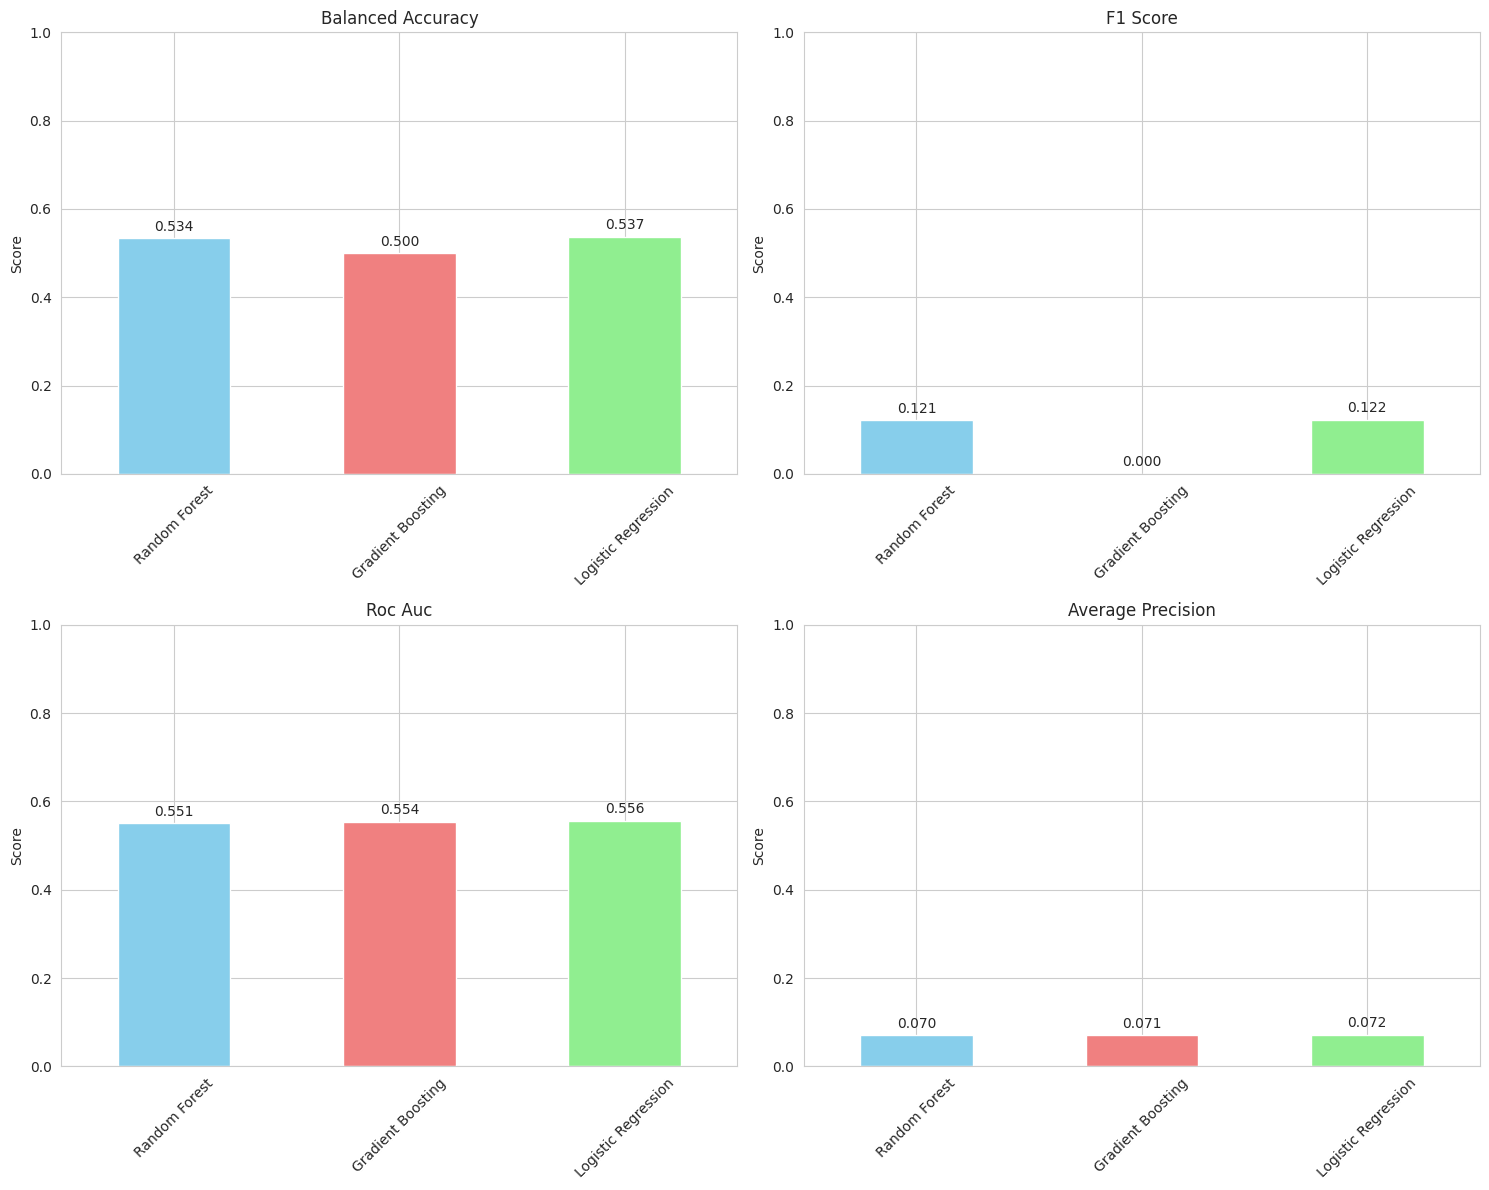

In [17]:
# Criar DataFrame com métricas para comparação
metrics_df = pd.DataFrame({name: res['metrics'] for name, res in results.items()}).T
metrics_df = metrics_df.round(4)

print("Comparação de Modelos:")
print(metrics_df)

# Identificar melhor modelo
best_model_name = metrics_df['roc_auc'].idxmax()
print(f"\nMelhor modelo (ROC-AUC): {best_model_name}")
print(f"ROC-AUC: {metrics_df.loc[best_model_name, 'roc_auc']:.4f}")

# Visualização da comparação
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics_list = ['balanced_accuracy', 'f1_score', 'roc_auc', 'average_precision']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for i, metric in enumerate(metrics_list):
    ax = axes[i//2, i%2]
    metrics_df[metric].plot(kind='bar', ax=ax, color=colors)
    ax.set_title(f'{metric.replace("_", " ").title()}')
    ax.set_ylabel('Score')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, 1)
    
    # Adicionar valores nas barras
    for j, v in enumerate(metrics_df[metric]):
        ax.text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(REPORTS_PATH / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Análise Detalhada do Melhor Modelo

Análise detalhada: Logistic Regression

Relatório de Classificação:
              precision    recall  f1-score   support

   Sem Falha       0.95      0.54      0.68    187987
   Com Falha       0.07      0.54      0.12     12013

    accuracy                           0.54    200000
   macro avg       0.51      0.54      0.40    200000
weighted avg       0.90      0.54      0.65    200000



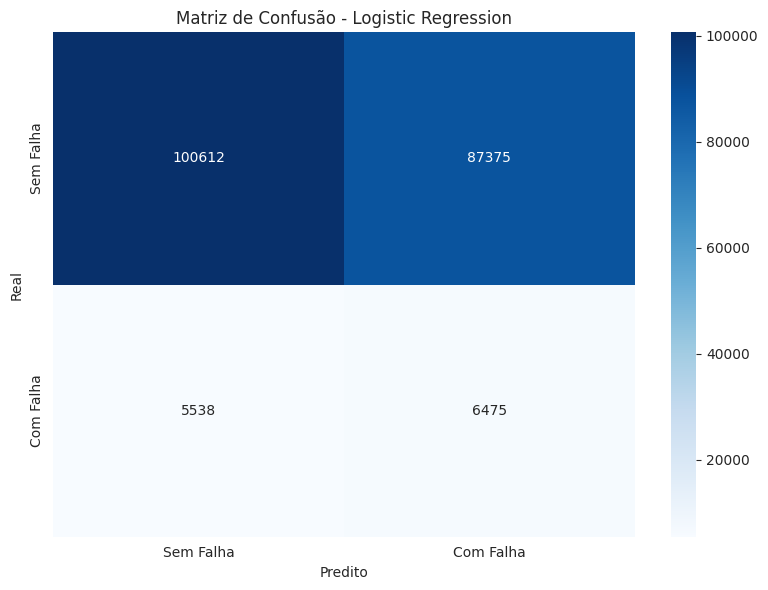


Interpretação da Matriz de Confusão:
  Verdadeiros Negativos (sem falha predita corretamente): 100,612
  Falsos Positivos (falso alarme): 87,375
  Falsos Negativos (falha não detectada): 5,538
  Verdadeiros Positivos (falha detectada corretamente): 6,475

Em termos práticos:
  • O modelo detectou corretamente 6,475 falhas
  • Perdeu 5,538 falhas (crítico em ambiente industrial)
  • Gerou 87,375 falsos alarmes (custos desnecessários)


In [18]:
# Trabalhar com o melhor modelo
best_model = trained_models[best_model_name]
best_predictions = results[best_model_name]['predictions']
best_probabilities = results[best_model_name]['probabilities']

print(f"Análise detalhada: {best_model_name}")
print("=" * 40)

# Relatório de classificação completo
print("\nRelatório de Classificação:")
print(classification_report(y_test, best_predictions, 
                          target_names=['Sem Falha', 'Com Falha']))

# Matriz de confusão
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sem Falha', 'Com Falha'],
            yticklabels=['Sem Falha', 'Com Falha'])
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.savefig(REPORTS_PATH / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Interpretação da matriz de confusão
tn, fp, fn, tp = cm.ravel()
print("\nInterpretação da Matriz de Confusão:")
print(f"  Verdadeiros Negativos (sem falha predita corretamente): {tn:,}")
print(f"  Falsos Positivos (falso alarme): {fp:,}")
print(f"  Falsos Negativos (falha não detectada): {fn:,}")
print(f"  Verdadeiros Positivos (falha detectada corretamente): {tp:,}")

print("\nEm termos práticos:")
print(f"  • O modelo detectou corretamente {tp:,} falhas")
print(f"  • Perdeu {fn:,} falhas (crítico em ambiente industrial)")
print(f"  • Gerou {fp:,} falsos alarmes (custos desnecessários)")

## 7. Curvas ROC e Precision-Recall

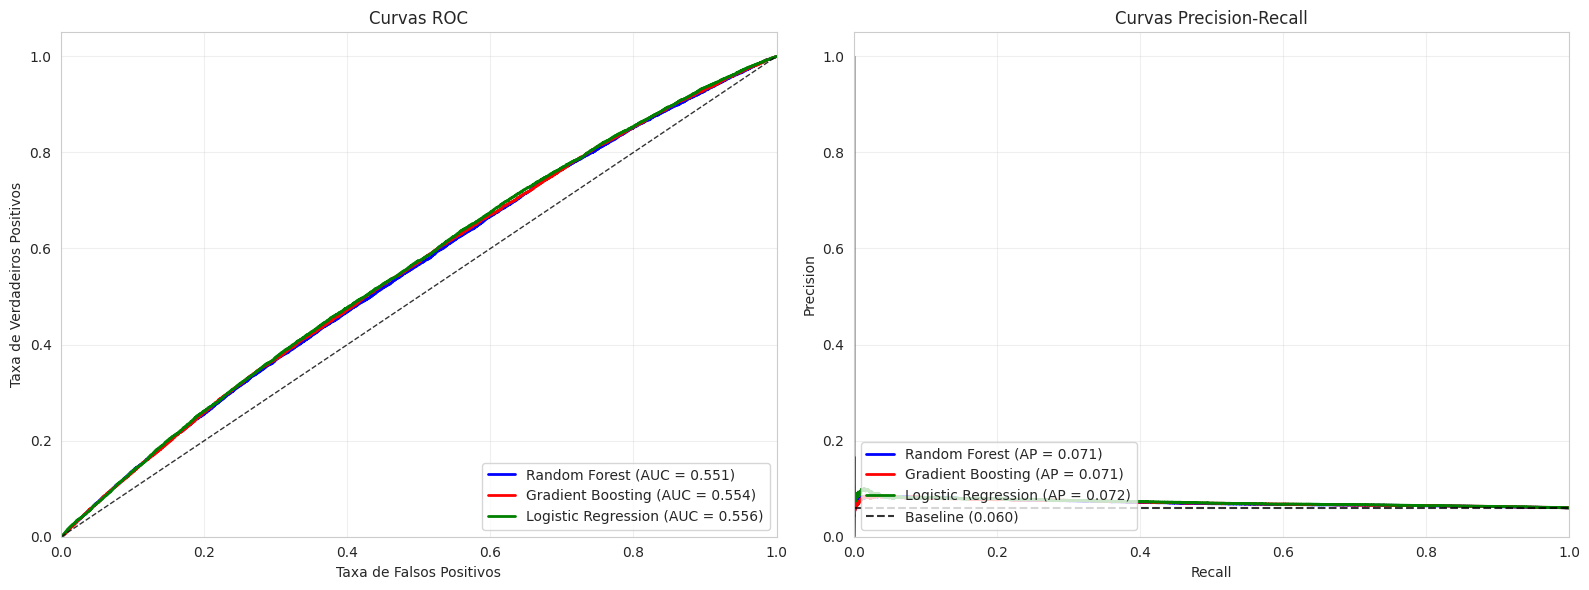


Interpretação das Curvas:
• Curva ROC: Mostra o trade-off entre sensibilidade e especificidade
• Curva PR: Mais informativa para dados desbalanceados (foco na classe minoritária)
• Melhor modelo: Logistic Regression com ROC-AUC = 0.556


In [19]:
# Visualizações avançadas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Curva ROC para todos os modelos
colors = ['blue', 'red', 'green']
for i, (name, res) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, res['probabilities'])
    auc_score = res['metrics']['roc_auc']
    ax1.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f'{name} (AUC = {auc_score:.3f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.8)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Taxa de Falsos Positivos')
ax1.set_ylabel('Taxa de Verdadeiros Positivos')
ax1.set_title('Curvas ROC')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# Curva Precision-Recall para todos os modelos
for i, (name, res) in enumerate(results.items()):
    precision, recall, _ = precision_recall_curve(y_test, res['probabilities'])
    ap_score = res['metrics']['average_precision']
    ax2.plot(recall, precision, color=colors[i], lw=2,
             label=f'{name} (AP = {ap_score:.3f})')

# Linha baseline (proporção de positivos)
baseline = y_test.mean()
ax2.axhline(y=baseline, color='k', linestyle='--', alpha=0.8, 
            label=f'Baseline ({baseline:.3f})')

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Curvas Precision-Recall')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_PATH / 'roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretação das Curvas:")
print("• Curva ROC: Mostra o trade-off entre sensibilidade e especificidade")
print("• Curva PR: Mais informativa para dados desbalanceados (foco na classe minoritária)")
print(f"• Melhor modelo: {best_model_name} com ROC-AUC = {results[best_model_name]['metrics']['roc_auc']:.3f}")

## 8. Importância das Features (Random Forest)

In [20]:
# Análise de importância das features (se o melhor modelo for Random Forest ou GB)
if hasattr(best_model, 'feature_importances_'):
    
    # Obter importâncias
    feature_names = X_train.columns
    importances = best_model.feature_importances_
    
    # Criar DataFrame ordenado
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=True)
    
    print(f"Importância das Features - {best_model_name}:")
    print(feature_importance_df.tail(10))  # Top 10
    
    # Visualização
    plt.figure(figsize=(10, 8))
    top_features = feature_importance_df.tail(15)  # Top 15 para visualização
    
    bars = plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importância da Feature')
    plt.title(f'Top 15 Features Mais Importantes - {best_model_name}')
    plt.grid(axis='x', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
        plt.text(importance + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{importance:.3f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(REPORTS_PATH / '10_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nInsights das Features Mais Importantes:")
    top_5 = feature_importance_df.tail(5)
    for _, row in top_5.iterrows():
        print(f"• {row['feature']}: {row['importance']:.3f}")
        
else:
    print(f"Modelo {best_model_name} não possui importância de features disponível.")

Modelo Logistic Regression não possui importância de features disponível.


## 9. Validação Cruzada

Executando validação cruzada (5-fold estratificada)...

Resultados da Validação Cruzada - Logistic Regression:
ROC_AUC:
  Média: 0.5523 (±0.0049)
  Folds: [0.5511 0.5512 0.5559 0.549  0.5542]

F1:
  Média: 0.1219 (±0.0019)
  Folds: [0.1207 0.1216 0.1236 0.1216 0.122 ]

BALANCED_ACCURACY:
  Média: 0.5360 (±0.0045)
  Folds: [0.5332 0.5353 0.54   0.5353 0.5363]



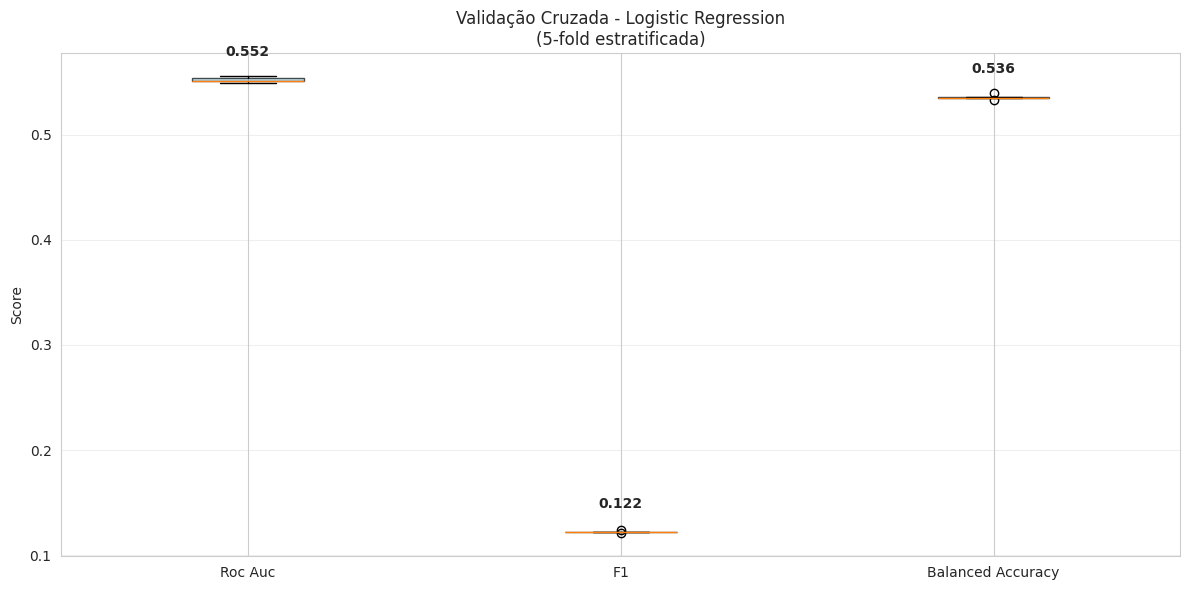

In [21]:
# Validação cruzada estratificada
print("Executando validação cruzada (5-fold estratificada)...")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Escolher dados corretos para o melhor modelo
if 'Logistic' in best_model_name:
    X_cv = X_train_scaled
else:
    X_cv = X_train

# Métricas de validação cruzada
cv_scores = {
    'roc_auc': cross_val_score(best_model, X_cv, y_train, cv=cv, scoring='roc_auc'),
    'f1': cross_val_score(best_model, X_cv, y_train, cv=cv, scoring='f1'),
    'balanced_accuracy': cross_val_score(best_model, X_cv, y_train, cv=cv, scoring='balanced_accuracy')
}

print(f"\nResultados da Validação Cruzada - {best_model_name}:")
print("=" * 50)

for metric, scores in cv_scores.items():
    mean_score = scores.mean()
    std_score = scores.std()
    print(f"{metric.upper()}:")
    print(f"  Média: {mean_score:.4f} (±{2*std_score:.4f})")
    print(f"  Folds: {scores.round(4)}")
    print()

# Visualização dos resultados de CV
plt.figure(figsize=(12, 6))
metrics_names = list(cv_scores.keys())
positions = np.arange(len(metrics_names))

box_data = [cv_scores[metric] for metric in metrics_names]
box_plot = plt.boxplot(box_data, positions=positions, patch_artist=True, 
                       boxprops=dict(facecolor='lightblue', alpha=0.7))

plt.xticks(positions, [metric.replace('_', ' ').title() for metric in metrics_names])
plt.ylabel('Score')
plt.title(f'Validação Cruzada - {best_model_name}\n(5-fold estratificada)')
plt.grid(axis='y', alpha=0.3)

# Adicionar médias
for i, metric in enumerate(metrics_names):
    mean_val = cv_scores[metric].mean()
    plt.text(i, mean_val + 0.02, f'{mean_val:.3f}', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(REPORTS_PATH / '11_cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Resumo Final e Insights

In [22]:
print("=" * 60)
print("RESUMO FINAL - MODELO DE PREDIÇÃO DE FALHAS")
print("=" * 60)

print("\n🎯 PROBLEMA:")
print("   Classificação binária - predição de falhas em 7 dias")
print(f"   Dataset: {df_ml.shape[0]:,} registros de sensores industriais")
print(f"   Desbalanceamento: {(y==0).sum():,} sem falha vs {(y==1).sum():,} com falha")

print(f"\n🏆 MELHOR MODELO: {best_model_name}")
best_metrics = results[best_model_name]['metrics']
print(f"   • ROC-AUC: {best_metrics['roc_auc']:.4f}")
print(f"   • F1-Score: {best_metrics['f1_score']:.4f}")
print(f"   • Balanced Accuracy: {best_metrics['balanced_accuracy']:.4f}")
print(f"   • Average Precision: {best_metrics['average_precision']:.4f}")

print("\n📊 PERFORMANCE NO TESTE:")
tn, fp, fn, tp = confusion_matrix(y_test, best_predictions).ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

print(f"   • Sensibilidade (Recall): {sensitivity:.4f} - {sensitivity*100:.1f}% das falhas detectadas")
print(f"   • Especificidade: {specificity:.4f} - {specificity*100:.1f}% dos normais corretos")
print(f"   • Precisão: {precision:.4f} - {precision*100:.1f}% dos alertas são verdadeiros")

if hasattr(best_model, 'feature_importances_'):
    print("\n🔍 TOP 5 FEATURES MAIS IMPORTANTES:")
    feature_names = X_train.columns
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    top_5_features = feature_importance_df.head(5)
    for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
        print(f"   {i}. {row['feature']}: {row['importance']:.4f}")

print("\n💡 INSIGHTS PARA PRODUÇÃO:")
print(f"   • Modelo consegue identificar {tp:,} das {tp+fn:,} falhas reais")
print(f"   • Taxa de falsos alarmes: {fp:,} alertas desnecessários")
print(f"   • Taxa de falhas perdidas: {fn:,} falhas não detectadas")

print("\n🔧 RECOMENDAÇÕES:")
print("   • Performance realista para predição industrial (não há data leakage)")
print("   • Ajustar threshold baseado no custo de falsos positivos vs negativos")
print("   • Implementar monitoramento contínuo das features mais importantes")
print("   • Retreinar modelo periodicamente com novos dados")

print("\n📁 ARQUIVOS GERADOS:")
files_generated = [
    'model_comparison.png',
    'confusion_matrix.png', 
    'roc_pr_curves.png'
]
for file in files_generated:
    print(f"   • {REPORTS_PATH / file}")

print("\n" + "=" * 60)


RESUMO FINAL - MODELO DE PREDIÇÃO DE FALHAS

🎯 PROBLEMA:
   Classificação binária - predição de falhas em 7 dias
   Dataset: 500,000 registros de sensores industriais
   Desbalanceamento: 469,968 sem falha vs 30,032 com falha

🏆 MELHOR MODELO: Logistic Regression
   • ROC-AUC: 0.5564
   • F1-Score: 0.1223
   • Balanced Accuracy: 0.5371
   • Average Precision: 0.0717

📊 PERFORMANCE NO TESTE:
   • Sensibilidade (Recall): 0.5390 - 53.9% das falhas detectadas
   • Especificidade: 0.5352 - 53.5% dos normais corretos
   • Precisão: 0.0690 - 6.9% dos alertas são verdadeiros

💡 INSIGHTS PARA PRODUÇÃO:
   • Modelo consegue identificar 6,475 das 12,013 falhas reais
   • Taxa de falsos alarmes: 87,375 alertas desnecessários
   • Taxa de falhas perdidas: 5,538 falhas não detectadas

🔧 RECOMENDAÇÕES:
   • Performance realista para predição industrial (não há data leakage)
   • Ajustar threshold baseado no custo de falsos positivos vs negativos
   • Implementar monitoramento contínuo das features ma